# Naver Conversation of the Day

![Conversation of the Day](https://raw.githubusercontent.com/rareloto/workspace/master/naverdictionary-conversationoftheday-scraper/naver-conversationoftheday-20200815-cropped.png)

Hi! Welcome to my notebook.

I want to create a compilation of **Korean - English sentence pairs** from **Naver Dictionary's Conversation of the Day**.

At first I thought, I could type them out one by one, day by day to reinforce my Korean language learning in addition to creating a dataset for future projects (*like maybe a bilingual AI chatbot*).

But then, I remembered something called **'web scraping'**. Simply put, it is a technique of automatically extracting (*or scraping*) specific data you want from websites and saving them to a file or a database.

In this notebook, I'm going to take my first dip in web scraping in order to compile months, years of 'Conversation of the Day' from [Naver Dictionary](https://learn.dict.naver.com/conversation#/korean-en).

# What I'm Expecting to Get From Scraping

In [1]:
import pandas as pd

convo_samp = pd.read_csv('../input/naver-dictionary-conversation-of-the-day/2008.csv').fillna('')
convo_samp[['date', 'conversation_id', 'kor_sent', 'eng_sent']]

,date,conversation_id,kor_sent,eng_sent
0,20200817,0,,
1,20200817,1,스티브 씨도 오늘 동호외 모임에 갈 가지요?,"Mr. Steve, are you going to the club meeting?"
2,20200817,2,서연 씨도 갈까요?,"Is Ms. Seoyon going, too?"
3,20200817,3,특별한 일이 없으니까 아마 갈 거예요.,Maybe she will go because she has nothing spec...
4,20200817,4,그럼 저도 갈게요.,"Then, I will go, too."
5,20200817,5,혹시 서연 씨에게 관심 있는 거 아니에요?,"By any chance, isn't it true that you are inte..."
6,20200817,6,서연 씨에게 말하지 마세요. 비밀이에요,Don't tell Ms. Seoyon. It's a secret


In [2]:
print('Other columns:\n', list(convo_samp.columns))

Other columns:
 ['date', 'conversation_id', 'kor_sent', 'eng_sent', 'kor_title', 'eng_title', 'grammar', 'grammar_desc', 'grammar_kor_sent1', 'grammar_eng_sent1', 'grammar_kor_sent2', 'grammar_eng_sent2', 'grammar_kor_sent3', 'grammar_eng_sent3']


In [3]:
import urllib.request
import re

# Let's try one webpage for now
url = 'https://learn.dict.naver.com/conversation#/korean-en'

page = urllib.request.urlopen(url)
page = str(page.read().decode())

# problem: not retrieving complete page html like Firefox html download does
#          BeautifulSoup doesn't seem to retrieve complete html either
# possible solution: should i try using headless firefox?
# solved! - In-kernel Web scraping via a headless Firefox browser with Selenium at the bottom page

**Find patterns in the html code around the data we want to extract**

![View source code](https://raw.githubusercontent.com/rareloto/workspace/master/naverdictionary-conversationoftheday-scraper/photos/view-page-source-find-patterns-koreng.png)

**Extract data from html:** 

*Korean - English sentence pairs, grammar, related words, date*

In [4]:
# regex to find conversation date
date = re.findall(r'var regionDate = "([0-9]+)"', page)
# regex to find conversation title
convo_title = re.findall(r'id="ogTitle" content="(.+)">', page)
# regex to extract sentence pairs
eng_sents = re.findall(r'<div class="txt_trans ng-binding" ng-show="transDisplay" ng-bind="item.trsl_sentence">(.+)<.div>', page)
# how to strip html from text - jxb-bind-compiled-html binding ?
kor_sents = re.findall(r'<span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">(.+)</span>.</span></span>', page)

# extracting other data (e.g. conversation title, grammar, grammar description, related words)

**Let's see if we're able to extract the data**

In [5]:
date

['20200818']

In [6]:
kor_sents

[]

In [7]:
eng_sents

[]

The sentence pairs were not extracted because the page source we retrieved is incomplete.

Maybe I'll try a headless Firefox browser here to download the complete webpage from the browser.

# Web Scraping via headless Firefox with Selenium

Installing Firefox browser

In [8]:
# Checking kernel OS info
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.4 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.4 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


Cool! Just like what I'm using right now.

In [9]:
# Downloading Firefox for Linux
!wget 'https://download-installer.cdn.mozilla.net/pub/firefox/releases/79.0/linux-x86_64/en-US/firefox-79.0.tar.bz2'

# Extracting Firefox binary
!tar -xjf 'firefox-79.0.tar.bz2'

--2020-08-18 06:28:39--  https://download-installer.cdn.mozilla.net/pub/firefox/releases/79.0/linux-x86_64/en-US/firefox-79.0.tar.bz2
Resolving download-installer.cdn.mozilla.net (download-installer.cdn.mozilla.net)... 143.204.134.60, 2600:9000:21c4:f800:e:19d6:1546:5981, 2600:9000:21c4:7e00:e:19d6:1546:5981, ...
Connecting to download-installer.cdn.mozilla.net (download-installer.cdn.mozilla.net)|143.204.134.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71210168 (68M) [application/x-tar]
Saving to: ‘firefox-79.0.tar.bz2’

firefox-79.0.tar.bz 100%[===================>]  67.91M  12.3MB/s    in 6.1s    

2020-08-18 06:28:45 (11.1 MB/s) - ‘firefox-79.0.tar.bz2’ saved [71210168/71210168]



In [10]:
# Checking working directory
!ls /kaggle/working

__notebook__.ipynb  firefox  firefox-79.0.tar.bz2


In [11]:
# Adding read/write/execute capabilities to 'firefox' directory
!chmod -R 777 '../working/firefox'

In [12]:
# Installing Firefox dependencies
!apt-get install -y libgtk-3-0 libdbus-glib-1-2 xvfb




libgtk-3-0 is already the newest version (3.22.30-1ubuntu4).
libgtk-3-0 set to manually installed.
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following NEW packages will be installed:
  libdbus-glib-1-2
0 upgraded, 1 newly installed, 0 to remove and 66 not upgraded.
Need to get 58.3 kB of archives.
After this operation, 203 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libdbus-glib-1-2 amd64 0.110-2 [58.3 kB]
Fetched 58.3 kB in 2s (24.4 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libdbus-glib-1-2:amd64.
(Reading database ... 107896 files and directories currently installed.)
Preparing to unpack .../libdbus-glib-1-2_0.110-2_amd64.deb ...
Unpacking libdbus-glib-1-2:amd64 (0.110-2) ...
Setting up libdbus-glib-1-2:amd64 (0.110-2) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...


Installing GeckoDriver 

In [13]:
# Installing Python module for automatic handling of GeckoDriver download and installation
!pip install webdriverdownloader

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
# Installing GeckoDriver
from webdriverdownloader import GeckoDriverDownloader

gdd = GeckoDriverDownloader()
gdd.download_and_install('v0.23.0')

3786kb [00:01, 2577.29kb/s]                        


('/usr/local/webdriver/gecko/v0.23.0/geckodriver-v0.23.0-linux64/geckodriver',
 '/usr/local/bin/geckodriver')

In [15]:
# Installing Selenium
!pip install selenium

     |████████████████████████████████| 904 kB 192 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
# Loading Python modules to use
import pandas as pd
import seaborn as sns
from IPython.display import Image
import time

from selenium import webdriver as selenium_webdriver
from selenium.webdriver.firefox.options import Options as selenium_options
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities as selenium_DesiredCapabilities

from selenium.webdriver.common.by  import By as selenium_By
from selenium.webdriver.support.ui import Select as selenium_Select
from selenium.webdriver.support.ui import WebDriverWait as selenium_WebDriverWait
from selenium.webdriver.support    import expected_conditions as selenium_ec

In [17]:
# Setting up a virtual screen for Firefox
!export DISPLAY=:99

In [18]:
# Firing up a headless browser session with a screen size of 1920x1080
browser_options = selenium_options()
browser_options.add_argument("--headless")
browser_options.add_argument("--window-size=1920,1080")

capabilities_argument = selenium_DesiredCapabilities().FIREFOX
capabilities_argument["marionette"] = True

browser = selenium_webdriver.Firefox(
    options=browser_options,
    firefox_binary="../working/firefox/firefox",
    capabilities=capabilities_argument
)

https://learn.dict.naver.com/conversation#/korean-en


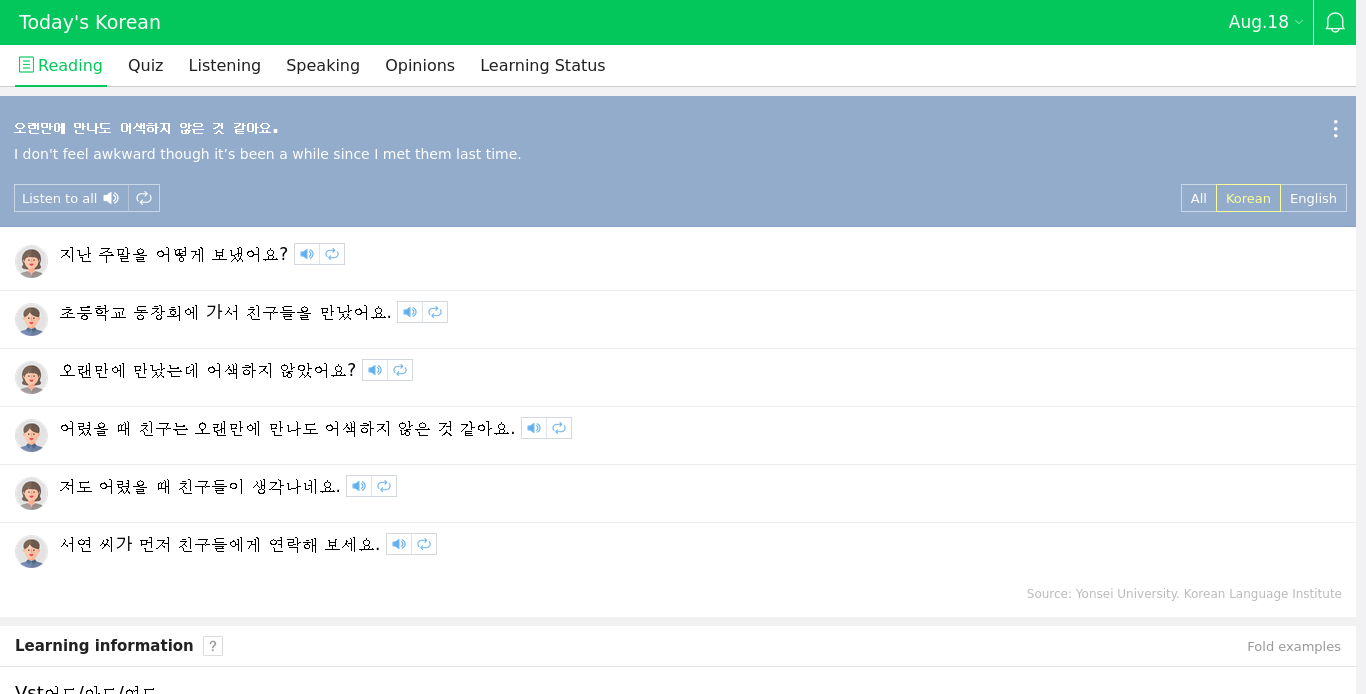

In [19]:
# Navigating to website
browser.get("https://learn.dict.naver.com/conversation#/korean-en")
print(browser.current_url)

# Giving the page up to 10 seconds to load
wait = selenium_WebDriverWait(browser, 10)
wait.until(selenium_ec.visibility_of_element_located((selenium_By.XPATH, '//div[@class="reading_lst_wrap"]')))

# Taking a screenshot of the webpage
browser.save_screenshot("screenshot.png")
Image("screenshot.png", width=800, height=500)

Awesome! Looks like we're on the same page.

**Viewing page source**

In [20]:
# Waiting for another 10 seconds to make sure the page is complete
time.sleep(10)

# Retrieving page source
page = browser.page_source
page[0:1000]

'<html xml:lang="ko" ng-app="mainApp" ng-controller="htmlController" class="ng-scope"><head><style type="text/css">@charset "UTF-8";[ng\\:cloak],[ng-cloak],[data-ng-cloak],[x-ng-cloak],.ng-cloak,.x-ng-cloak,.ng-hide:not(.ng-hide-animate){display:none !important;}ng\\:form{display:block;}.ng-animate-shim{visibility:hidden;}.ng-anchor{position:absolute;}</style>\n\t\t<meta charset="utf-8">\n\t\t<meta http-equiv="X-XSS-Protection" content="1">\n\t\t<meta name="viewport" id="viewport" content="initial-scale=1.0,minimum-scale=1.0,maximum-scale=1.0,user-scalable=no">\n\t\t<!-- for Facebook -->\n\t\t<meta property="og:title" id="ogTitle" content="오늘의 회화 - 오랜만에 만나도 어색하지 않은 것 같아요.">\n\t\t<meta property="og:type" content="article">\n\t\t<meta property="og:description" id="ogDesc" content="오늘은 어떤 내용일까요? 지금 확인해보세요!">\n\t\t<meta property="og:image" content="https://ssl.pstatic.net/dicimg/wordbook-mobile-endic/img/enwordbook_icon_20171204.png">\n\t\t<meta property="og:url" id="ogUrl" content="http:/

A bit messy.. Let's use regular expressions to find what we need.

In [21]:
# regex to extract conversation date
date = re.findall(r'var regionDate = "([0-9]+)"', page)
# regex to extract conversation title in korean
kor_title = re.findall(r'id="ogTitle" content="오늘의 회화 - (.+)">', page)
# regex to extract conversation title in english
eng_title = re.findall(r'<span class="txt_trans ng-binding" ng-bind="title_translation">(.+)</span>', page)
# regex to extract sentence pairs
eng_sents = re.findall(r'<div.+item.trsl_sentence">(.+)</div>', page)
kor_sents = re.findall(r'<span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">(.+)</span></span>', page)

Did we get it?

In [22]:
date

['20200818']

In [23]:
kor_title

['오랜만에 만나도 어색하지 않은 것 같아요.']

In [24]:
eng_title

["I don't feel awkward though it’s been a while since I met them last time."]

In [25]:
eng_sents

['How did you spend your weekend?',
 'I went to my elementary school alumni meeting, where I met some friends.',
 "Didn’t you feel awkward because it's been a while since you met them?",
 "I don't feel awkward though it’s been a while since I met my friends from my childhood when I was young.",
 'I remember my friends from my childhood when I was young.',
 "Ms. Seoyon, why don't you first contact your friends?"]

In [26]:
kor_sents[0:5]

['지난</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">주말을</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">어떻게</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">보냈어요</span>?',
 '초등학교</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">동창회에</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">가서</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">친구들을</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">만났어요</span>.',
 '오랜만에</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">만났는데</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">어색하지</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">않았어요</span>?',
 '어렸을</span> <span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">때</span>

In [27]:
# Stripping HTML tags from text
def strip_tags(sent):
    sent = re.sub(r'<.+?>', '', sent)
    return sent

In [28]:
kor_sents = list(map(strip_tags, kor_sents))
kor_sents = kor_sents[0:len(eng_sents)]
kor_sents

['지난 주말을 어떻게 보냈어요?',
 '초등학교 동창회에 가서 친구들을 만났어요.',
 '오랜만에 만났는데 어색하지 않았어요?',
 '어렸을 때 친구는 오랜만에 만나도 어색하지 않은 것 같아요.',
 '저도 어렸을 때 친구들이 생각나네요.',
 '서연 씨가 먼저 친구들에게 연락해 보세요.']

Sweet!

**Extracting more variables**

In [29]:
# Extracting grammar of the day
grammar = re.findall(r'<span jxb-bind-compiled-html.+item[.]entry_name.+"ng-scope">(.+)</span></span>\s+</div>', page)
grammar = list(map(strip_tags, grammar))
grammar

['Vst어도/아도/여도']

In [30]:
# Extracting grammar description
grammar_desc = re.findall(r'<span class="txt_trans ng-binding" ng-bind="item.mean">(.+)</span>\s+</div>', page)
grammar_desc = list(map(strip_tags, grammar_desc))
grammar_desc

['It is used to indicate the contents of the latter clause are unpredictable consequences from the contents of the preceding clause.']

In [31]:
# Extracting grammar of the day sentence examples
grammar_sents_eng = re.findall(r'<span class="txt_trans ng-binding" ng-bind-html="desc[.]trans.+toHtml">(.+)</span>', page)
grammar_sents_eng

["There will be good results if you endure and work hard though it's difficult.",
 'Are you going on a trip though it rains?',
 "I always brush my teeth though I'm tired."]

In [32]:
grammar_sents_kor = re.findall(r'<span class="txt_origin ng-isolate-scope" jxb-bind-compiled-html="toAutolinkText\(desc[.]origin\)"><span class="ng-scope"><span class="u_word_dic" data-hook="tip" data-type="arken" data-lang="ko">(.+)</span></span>', page)
grammar_sents_kor = list(map(strip_tags, grammar_sents_kor))
grammar_sents_kor

['힘들어도 참고 열심히 일하면 좋은 결과가 있을 거예요.', '비가 와도 여행을 갈 거야?', '저는 피곤해도 이를 꼭 닦고 자요.']

**Organizing variables for DataFrame creation**

Let's create two DataFrames:

**convo_titles**
(with columns: date, kor_title, eng_title, grammar, grammar_desc, grammar_sents)

**convos**
(with columns: date, conversation_id, kor_sent, eng_sent, qna_id)

Each convo_title has more or less 4 - 8 Korean-English sentence pairs found in convos_table.

Creating convo_titles DataFrame

In [33]:
# convo_titles dataframe columns
title_cols = {
    'date': date,
    'kor_title': kor_title,
    'eng_title': eng_title,
    'grammar': grammar,
    'grammar_desc': grammar_desc
}

# Creating convo_titles DataFrame
convo_titles = pd.DataFrame(title_cols)
convo_titles

,date,kor_title,eng_title,grammar,grammar_desc
0,20200818,오랜만에 만나도 어색하지 않은 것 같아요.,I don't feel awkward though it’s been a while ...,Vst어도/아도/여도,It is used to indicate the contents of the lat...


In [34]:
# Adding new columns: grammar sentence examples    
for i in range(len(grammar_sents_eng)):
    col = f'grammar_kor_sent_{i+1}'
    convo_titles[col] = grammar_sents_kor[i]
    col = f'grammar_eng_sent_{i+1}'
    convo_titles[col] = grammar_sents_eng[i]
    
convo_titles

,date,kor_title,eng_title,grammar,grammar_desc,grammar_kor_sent_1,grammar_eng_sent_1,grammar_kor_sent_2,grammar_eng_sent_2,grammar_kor_sent_3,grammar_eng_sent_3
0,20200818,오랜만에 만나도 어색하지 않은 것 같아요.,I don't feel awkward though it’s been a while ...,Vst어도/아도/여도,It is used to indicate the contents of the lat...,힘들어도 참고 열심히 일하면 좋은 결과가 있을 거예요.,There will be good results if you endure and w...,비가 와도 여행을 갈 거야?,Are you going on a trip though it rains?,저는 피곤해도 이를 꼭 닦고 자요.,I always brush my teeth though I'm tired.


Creating convos DataFrame

In [35]:
# convos dataframe columns
convos_cols = {
    'date': [date for date in date for _ in range(len(eng_sents))],
    'conversation_id': [id+1 for id, _ in enumerate(eng_sents)],
    'kor_sent': kor_sents,
    'eng_sent': eng_sents,
    'qna_id': ''  # from sender or receiver, message or feedback
}

# Creating convos DataFrame
convos = pd.DataFrame(convos_cols)
convos

,date,conversation_id,kor_sent,eng_sent,qna_id
0,20200818,1,지난 주말을 어떻게 보냈어요?,How did you spend your weekend?,
1,20200818,2,초등학교 동창회에 가서 친구들을 만났어요.,"I went to my elementary school alumni meeting,...",
2,20200818,3,오랜만에 만났는데 어색하지 않았어요?,Didn’t you feel awkward because it's been a wh...,
3,20200818,4,어렸을 때 친구는 오랜만에 만나도 어색하지 않은 것 같아요.,I don't feel awkward though it’s been a while ...,
4,20200818,5,저도 어렸을 때 친구들이 생각나네요.,I remember my friends from my childhood when I...,
5,20200818,6,서연 씨가 먼저 친구들에게 연락해 보세요.,"Ms. Seoyon, why don't you first contact your f...",


In [36]:
# Deleting unwanted files in working directory
!rm -rf firefox
!rm firefox-79.0.tar.bz2
!rm geckodriver.log
!ls ../working

__notebook__.ipynb  screenshot.png


**Save to file: conversations.csv, conversations_titles.csv**

In [37]:
convos.to_csv('conversations.csv', index = False)
convo_titles.to_csv('conversations_titles.csv', index = False)

Now, let's do these for years' worth of conversations via script.

**Up next:**
* Automation and scripting: Looping through dates, extracting conversation per date
* Dataset creation: Making the dataset user-friendly
* Applications: I could make tons of flashcards, for now

# References
* [K-MOOC: Python Web Scraping](http://blog.naver.com/PostView.nhn?blogId=powhy123&logNo=221193422772&categoryNo=19&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView)
* [Kaggle web scraping via headless Firefox+selenium](https://www.kaggle.com/dierickx3/kaggle-web-scraping-via-headless-firefox-selenium)